In [107]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

### Load data

In [108]:
selection_df = pd.read_pickle('../../data/processed/live_selections.pkl')

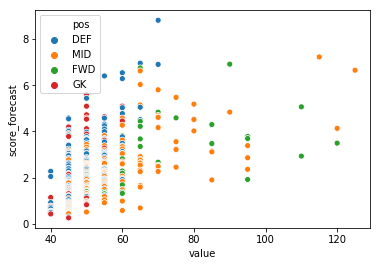

In [109]:
sns.scatterplot(data=selection_df,x='value',y='score_forecast',hue='pos')

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

removing new-joiners, and manually dropping some guys that moved club

In [110]:
BLACKLIST = ['Chris_Wood','Marko_Arnautovic']

In [111]:
selection_df = selection_df.loc[~selection_df.clean_name.isin(BLACKLIST),:]

In [135]:
def select_best_11(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    liecester = dict(zip(player_ids,(data.team == 'Leicester City').astype(int)))
    liverpool = dict(zip(player_ids,(data.team == 'Liverpool').astype(int)))

    
    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 11, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 800, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 1, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) <= 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) <= 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) <= 3, "Less than 3 STR"
    prob += pulp.lpSum([liecester[i] * player_vars[i] for i in player_ids]) <= 3, "Less than 3 liecester"
    prob += pulp.lpSum([liverpool[i] * player_vars[i] for i in player_ids]) <= 3, "Less than 3 liverpool"

    
    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [136]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.value))
    gk = dict(zip(player_ids,(data.pos == 'GK').astype(int)))
    defe = dict(zip(player_ids,(data.pos == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.pos == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.pos == 'FWD').astype(int)))
    
    liecester = dict(zip(player_ids,(data.team == 'Leicester City').astype(int)))
    liverpool = dict(zip(player_ids,(data.team == 'Liverpool').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 1000, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([liecester[i] * player_vars[i] for i in player_ids]) <= 3, "Less than 3 liecester"
    prob += pulp.lpSum([liverpool[i] * player_vars[i] for i in player_ids]) <= 3, "Less than 3 liverpool"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [144]:
selection_df.loc[selection_df.clean_name == 'Raheem_Sterling','score_forecast'] = 7

In [145]:
_, _, selections_lgb_15 = select_best_15(selection_df,'score_forecast')

In [146]:
_, _, selections_lgb_11 = select_best_11(selection_df,'score_forecast')

In [147]:
def show_team(candidates, selection):
    position_map = {'GK':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.pos.map(position_map)
    return candidates.iloc[selection].sort_values(by='position_num').drop(columns='position_num')

In [148]:
selected_lgb_11 = show_team(selection_df,selections_lgb_11); selected_lgb_11

,clean_name,pos,team,score_forecast,value,selected_by_percent
207,Kasper_Schmeichel,GK,Leicester City,5.603575,50,5.1
361,Trent_Alexander-Arnold,DEF,Liverpool,8.811152,70,28.7
369,Virgil_van Dijk,DEF,Liverpool,6.953997,65,42.7
22,Andrew_Robertson,DEF,Liverpool,6.902782,70,36.2
2,Aaron_Wan-Bissaka,DEF,Manchester United,6.402908,55,32.4
227,Lucas_Digne,DEF,Everton,6.286767,60,27.8
281,Nathan_Redmond,MID,Southampton,6.033214,65,2.9
373,Wilfried_Zaha,MID,Crystal Palace,5.804067,70,30.9
309,Raheem_Sterling,MID,Manchester City,7.000000,120,25.4
384,Youri_Tielemans,MID,Leicester City,6.622786,65,5.7


In [149]:
selected_lgb_15 = show_team(selection_df,selections_lgb_15); selected_lgb_15

,clean_name,pos,team,score_forecast,value,selected_by_percent
207,Kasper_Schmeichel,GK,Leicester City,5.603575,50,5.1
231,Lukasz_Fabianski,GK,West Ham United,5.094775,50,10.2
361,Trent_Alexander-Arnold,DEF,Liverpool,8.811152,70,28.7
369,Virgil_van Dijk,DEF,Liverpool,6.953997,65,42.7
22,Andrew_Robertson,DEF,Liverpool,6.902782,70,36.2
2,Aaron_Wan-Bissaka,DEF,Manchester United,6.402908,55,32.4
227,Lucas_Digne,DEF,Everton,6.286767,60,27.8
281,Nathan_Redmond,MID,Southampton,6.033214,65,2.9
373,Wilfried_Zaha,MID,Crystal Palace,5.804067,70,30.9
326,Ryan_Fraser,MID,Bournemouth,5.476223,75,21.4


In [134]:
selected_lgb.value.sum()

1000